In [1]:
import os
import re
import string
import random

import keras
import numpy as np
import tensorflow as tf
from keras import layers

os.environ['XLA_FLAGS'] = f"--xla_gpu_cuda_data_dir={os.environ['CONDA_PREFIX']}/lib/"

# Machine Translation using Transformers

## 1 Data Preparation

### Data Acquisition

Run the code below if you haven't downloaded the English-to-Spanish translation dataset.

In [2]:
# !wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
# !unzip -q spa-eng.zip

In [3]:
text_file = "spa-eng/spa.txt"

with open(text_file) as f:
    lines = f.read().split("\n")[:-1]

Then, we prepend the start and end tokens to the Spanish sentence to match the general template of a seq-to-seq model. We save the english and spanish pairs to a list.

In [4]:
text_pairs = []
for line in lines:
    english, spanish = line.split("\t")
    spanish = "[start] " + spanish + " [end]"
    text_pairs.append((english, spanish))

In [5]:
len(text_pairs)

118964

In [6]:
random.choice(text_pairs)

("Don't drive under the influence of alcohol.",
 '[start] No conduzcas bajo la influencia del alcohol. [end]')

### Data Splitting

In [7]:
random.seed(143)
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples

train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

### Data Normalization

Apart from the usual standardization procedures done on text data, some additonal procedures that we should do are:
- Preserve our start and end tokens, `[start]` and `[end]`
- Additionally strip the character `¿`

In [8]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

In [9]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", ""
    )

### Text Vectorization

In [10]:
vocab_size = 15_000
sequence_length = 20

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1, # Offset by 1 step
    standardize=custom_standardization,
)

# Use training pairs to calibrate vectorizer
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

### Dataset Preparation

In [11]:
batch_size = 64

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)

    return ({"english": eng, "spanish": spa[:, :-1]}, spa[:, 1:])


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)

    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)

    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

## 2 Baseline: Seq-to-Seq Learning with RNNs

### Model Architecture

In [12]:
def make_seq2seq_rnn(embed_dim, latent_dim, vocab_size):
    # GRU Encoder
    source = keras.Input(shape=(None,), dtype="int64", name="english")

    x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)

    encoded_source = layers.Bidirectional(
        layers.GRU(latent_dim), merge_mode="sum")(x)

    # GRU Decoder
    past_target = keras.Input(shape=(None,), dtype="int64", name="spanish")

    x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)

    decoder_gru = layers.GRU(latent_dim, return_sequences=True)
    x = decoder_gru(x, initial_state=encoded_source)
    x = layers.Dropout(0.5)(x)

    # Decoder Output
    target_next_step = layers.Dense(vocab_size, activation="softmax")(x)

    return keras.Model([source, past_target], target_next_step)

### Model Training

In [13]:
embed_dim = 256
latent_dim = 1024

seq2seq_rnn = make_seq2seq_rnn(embed_dim, latent_dim, vocab_size)
seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

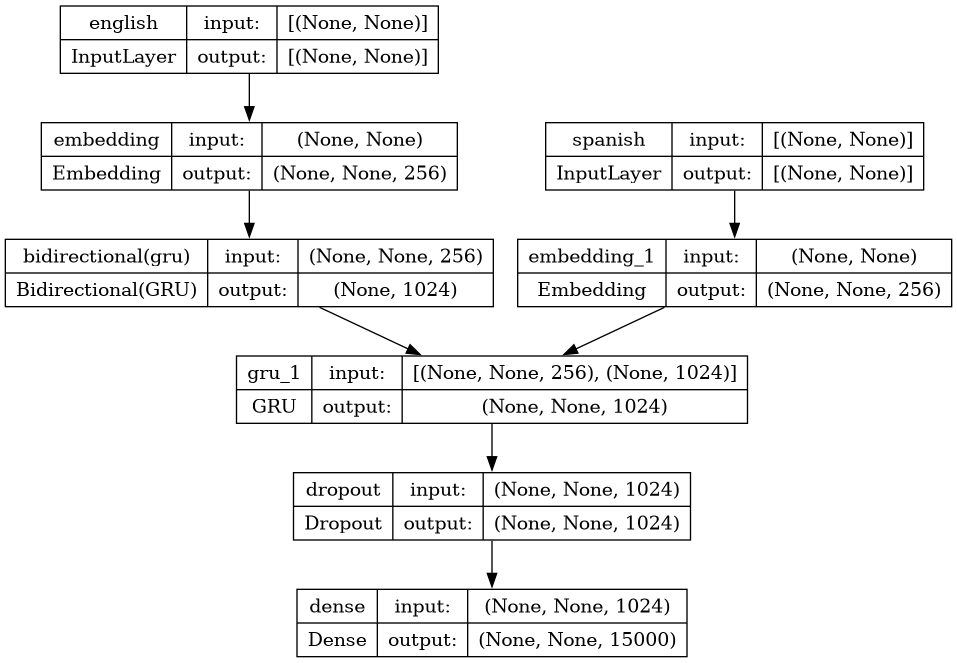

In [14]:
keras.utils.plot_model(seq2seq_rnn, show_shapes=True)

In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "seq2seq_rnn.tf", save_best_only=True)
]

In [16]:
history = seq2seq_rnn.fit(train_ds, validation_data=val_ds,
                          epochs=15, callbacks=callbacks)

Epoch 1/15
INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assetsoss: 4.6772 - accuracy: 0.3190         


INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assets


1302/1302 [==============================] - 120s 84ms/step - loss: 4.6766 - accuracy: 0.3191 - val_loss: 3.8929 - val_accuracy: 0.3841
Epoch 2/15
INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assetsoss: 3.7189 - accuracy: 0.4161  


INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assets


1302/1302 [==============================] - 90s 69ms/step - loss: 3.7189 - accuracy: 0.4161 - val_loss: 3.2424 - val_accuracy: 0.4688
Epoch 3/15
INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assetsoss: 3.2179 - accuracy: 0.4728  


INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assets


1302/1302 [==============================] - 91s 70ms/step - loss: 3.2179 - accuracy: 0.4728 - val_loss: 2.8820 - val_accuracy: 0.5126
Epoch 4/15
INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assetsoss: 2.8663 - accuracy: 0.5126  


INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assets


1302/1302 [==============================] - 89s 69ms/step - loss: 2.8663 - accuracy: 0.5126 - val_loss: 2.6335 - val_accuracy: 0.5490
Epoch 5/15
INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assetsoss: 2.5926 - accuracy: 0.5455  


INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assets


1302/1302 [==============================] - 89s 69ms/step - loss: 2.5926 - accuracy: 0.5455 - val_loss: 2.4388 - val_accuracy: 0.5778
Epoch 6/15
INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assetsoss: 2.3717 - accuracy: 0.5735  


INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assets


1302/1302 [==============================] - 90s 69ms/step - loss: 2.3717 - accuracy: 0.5735 - val_loss: 2.3167 - val_accuracy: 0.5960
Epoch 7/15
INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assetsoss: 2.1869 - accuracy: 0.5975  


INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assets


1302/1302 [==============================] - 90s 69ms/step - loss: 2.1868 - accuracy: 0.5975 - val_loss: 2.2228 - val_accuracy: 0.6113
Epoch 8/15
INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assetsoss: 2.0290 - accuracy: 0.6184  


INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assets


1302/1302 [==============================] - 89s 69ms/step - loss: 2.0288 - accuracy: 0.6184 - val_loss: 2.1467 - val_accuracy: 0.6231
Epoch 9/15
INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assetsoss: 1.8892 - accuracy: 0.6378  


INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assets


1302/1302 [==============================] - 90s 69ms/step - loss: 1.8892 - accuracy: 0.6378 - val_loss: 2.0956 - val_accuracy: 0.6326
Epoch 10/15
INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assetsoss: 1.7693 - accuracy: 0.6540  


INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assets


1302/1302 [==============================] - 89s 69ms/step - loss: 1.7692 - accuracy: 0.6540 - val_loss: 2.0486 - val_accuracy: 0.6389
Epoch 11/15
INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assetsoss: 1.6638 - accuracy: 0.6685  


INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assets


1302/1302 [==============================] - 91s 70ms/step - loss: 1.6638 - accuracy: 0.6685 - val_loss: 2.0092 - val_accuracy: 0.6449
Epoch 12/15
INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assetsoss: 1.5697 - accuracy: 0.6823  


INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assets


1302/1302 [==============================] - 91s 70ms/step - loss: 1.5697 - accuracy: 0.6823 - val_loss: 1.9868 - val_accuracy: 0.6493
Epoch 13/15
INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assetsoss: 1.4893 - accuracy: 0.6935  


INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assets


1302/1302 [==============================] - 90s 69ms/step - loss: 1.4893 - accuracy: 0.6935 - val_loss: 1.9641 - val_accuracy: 0.6548
Epoch 14/15
INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assetsoss: 1.4161 - accuracy: 0.7043  


INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assets


1302/1302 [==============================] - 89s 68ms/step - loss: 1.4160 - accuracy: 0.7043 - val_loss: 1.9458 - val_accuracy: 0.6561
Epoch 15/15
INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assetsoss: 1.3540 - accuracy: 0.7131  


INFO:tensorflow:Assets written to: seq2seq_rnn.tf/assets


1302/1302 [==============================] - 90s 69ms/step - loss: 1.3540 - accuracy: 0.7131 - val_loss: 1.9329 - val_accuracy: 0.6593


### Model Evaluation

In [17]:
seq2seq_rnn = keras.models.load_model("seq2seq_rnn.tf")

In [18]:
seq2seq_rnn.evaluate(val_ds)

279/279 [==============================] - 11s 28ms/step - loss: 1.9329 - accuracy: 0.6593


[1.9328864812850952, 0.6592968106269836]

In [19]:
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    # Tokenization of input
    tokenized_input_sentence = source_vectorization([input_sentence])

    # Text generation of translation
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        # Tokenize current target sequence
        tokenized_target_sentence = target_vectorization([decoded_sentence])

        # Generate next token prediction
        next_token_predictions = seq2seq_rnn.predict(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]

        # Update translation
        decoded_sentence += " " + sampled_token

        # Stop criterion
        if sampled_token == "[end]":
            break

    return decoded_sentence

In [20]:
test_eng_texts = [pair[0] for pair in test_pairs]
test_spa_texts = [pair[1] for pair in test_pairs]

# Choose text pair
i = 10

input_sentence = test_eng_texts[i]

print(f"\033[1m Input \033[0;0m: {input_sentence}\n")
print(f"\n\033[1m Machine Translation \033[0;0m: {decode_sequence(input_sentence)}")
print(f"\033[1m Actual \033[0;0m: {test_spa_texts[i]}\n")

 Input : That's exactly what I said would happen.

1/1 [==============================] - 0s 32ms/step

 Machine Translation : [start] eso es lo que dije que no he vuelto [end]
 Actual : [start] Eso es exactamente lo que dije que ocurriría. [end]



## 3 Seq-to-Seq Learning with Transformer

### Model Architecture

#### Transformer Encoder

In [21]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        # Initialization of layer attributes
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # Defining architecture components
        self.attention = layers.MultiHeadAttention(
            num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :] # expand mask dimension since attention layer expects 3d or 4d

        attention_output = self.attention(
            inputs, inputs, attention_mask=mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)

        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()

        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })

        return config

#### Positional Encoding

In [22]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        # Initialization of attributes
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Architectural components
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )

    def call(self, inputs):
        # Create position indices
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1, dtype="int64")

        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)

        return tf.add(embedded_tokens, embedded_positions)

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0) # Similar to embedding layer, this 
                                            # should generate a mask so we can
                                            # ignore padding 0s in the inputs

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim
        })

        return config

#### Transformer Decoder

In [23]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        # Initialize attributes
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # Architectural components
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True # Ensure that the layer will propage its input mask to its output


    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })

        return config


    def get_causal_attention_mask(self, inputs):
        # Get the input dimensions to properly shape mask
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]

        # Creates a matrix with 0 and 1 in each half
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))

        # Used as multiplier for tiling, creates a mask along the batch axis
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)

        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        # Consolidate mask from causal and padding mask
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
            padding_mask = mask

        # First multi-head attention layer
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)

        # Encoder output is introduced here
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )

        # Attention output from dense projections and layer norms
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)

        return self.layernorm_3(attention_output_2 + proj_output)

### Model Building

In [24]:
embed_dim = 256
dense_dim = 2048
num_heads = 8


def make_transformer():
    # Encoder
    encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
    x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
    encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

    # Decoder
    decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="spanish")
    x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
    x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
    x = layers.Dropout(0.5)(x)
    decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)

    return keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

### Model Training

In [25]:
transformer = make_transformer()

In [26]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

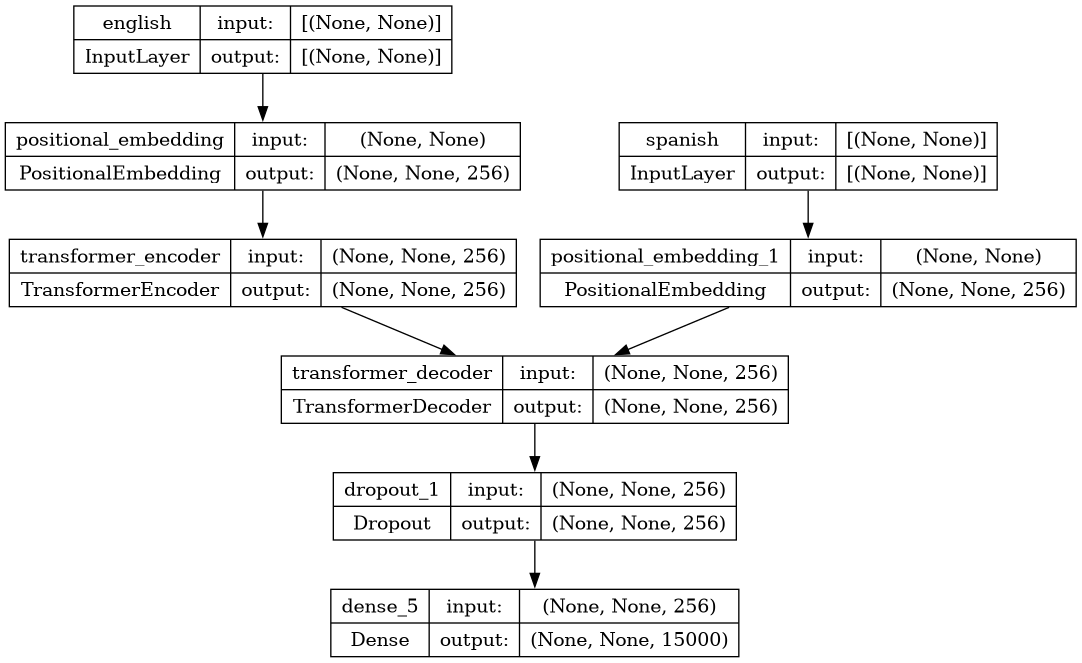

In [27]:
keras.utils.plot_model(transformer, show_shapes=True)

In [28]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "transformer.h5", save_best_only=True)
]

In [29]:
history = transformer.fit(train_ds, validation_data=val_ds,
                          epochs=20, callbacks=callbacks)

Epoch 1/20
1302/1302 [==============================] - ETA: 0s - loss: 3.7997 - accuracy: 0.4395         

/home/llorenzo/.conda/new_envs/msds2025ft-ml3-transformers/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1302/1302 [==============================] - 83s 59ms/step - loss: 3.7997 - accuracy: 0.4395 - val_loss: 2.8728 - val_accuracy: 0.5397
Epoch 2/20
1302/1302 [==============================] - 60s 46ms/step - loss: 2.8519 - accuracy: 0.5501 - val_loss: 2.5150 - val_accuracy: 0.5916
Epoch 3/20
1302/1302 [==============================] - 60s 46ms/step - loss: 2.5592 - accuracy: 0.5931 - val_loss: 2.3852 - val_accuracy: 0.6138
Epoch 4/20
1302/1302 [==============================] - 60s 46ms/step - loss: 2.3984 - accuracy: 0.6192 - val_loss: 2.3279 - val_accuracy: 0.6264
Epoch 5/20
1302/1302 [==============================] - 60s 46ms/step - loss: 2.2914 - accuracy: 0.6380 - val_loss: 2.3096 - val_accuracy: 0.6322
Epoch 6/20
1302/1302 [==============================] - 60s 46ms/step - loss: 2.2175 - accuracy: 0.6517 - val_loss: 2.2929 - val_accuracy: 0.6388
Epoch 7/20
1302/1302 [==============================] - 60s 46ms/step - loss: 2.1579 - accuracy: 0.6631 - val_loss: 2.2696 - val_accura

### Model Evaluation

In [30]:
transformer = keras.models.load_model(
    "transformer.h5",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding,
                    "TransformerDecoder": TransformerDecoder})

In [31]:
transformer.evaluate(val_ds)

279/279 [==============================] - 8s 26ms/step - loss: 2.2491 - accuracy: 0.6626


[2.2490713596343994, 0.6626129150390625]

In [32]:
max_decoded_sentence_length = 20

def decode_sequence_transformer(input_sentence):
    # Vectorized input sentence
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"

    # Generate predictions
    for i in range(max_decoded_sentence_length):
        # Vectorize target sentence
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]


        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]

        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break

    return decoded_sentence

In [33]:
test_eng_texts = [pair[0] for pair in test_pairs]
test_spa_texts = [pair[1] for pair in test_pairs]

# Choose text pair
i = 3

input_sentence = test_eng_texts[i]

print(f"\033[1m Input \033[0;0m: {input_sentence}\n")
print(f"\n\033[1m Machine Translation \033[0;0m: {decode_sequence_transformer(input_sentence)}")
print(f"\033[1m Actual \033[0;0m: {test_spa_texts[i]}\n")

 Input : Tom has a big family.


 Machine Translation : [start] tom tiene una familia grande [end]
 Actual : [start] Tom tiene una familia grande. [end]

